# 3. Comparing Classifiers
###### Ciaran Furey, 2021
This notebook will demonstrate how the sklearn ML algorithms were compared.

Firstly import the necessary modules.

In [1]:
#import modules
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pandas as pd
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

from sklearn.model_selection import GridSearchCV # this will do cross validation

import random

Sklearn raises warnings when the Gaussian Processes has not converged, or if the optimal kernel parameters are close to the specified bounds, however, it does not affect the final code. In order to ignore these warnings, uncomment and run the following cell.

In [2]:
import warnings
warnings.filterwarnings('ignore')

The `OpenSN` class. Though not completely necessary, it is useful to have when certain SNe are to be examined.

In [3]:
class OpenSN:
    '''
    - Class that will open supernova photometry in a desired band from Open Astronomy Catalog API (OACAPI).
    - Provides a range of data, including redshift, claimed type and distance modulus.
    - Since this was created for the purpose of training and testing machine learning
      algorithms, light curves are interpolated using Gaussian Processes.
    - Provides option to plot the light curve in either MJD, or within a desired day
      range.
      
    ----------
    Inputs:
    name: string, name of SN
    band: string, the band to observe the light curve in
    t_min: int, lower bound of time interval (days since max), default = -10
    t_max: int, upper bound of time interval (days since max), default = 40 (t_max > t_min)
    num_steps: int, number of points to interpolate to, default = 200 (num_steps > 0)
    day_range: bool, option to view light curve within a range of days since max (True)
               or in MJD (False), default = True
    abs_mag: bool, option to view in terms of absolute mag, calculated from luminosity distance (True),
             or apparent magnitude (False), default = True 
    check_source: bool, option to return light curve from one source only, or to include photometry
                  from multiple sources. If there is more than one source, the source with the most
                  amount of data point is used. For example, SN2012fr. Default = True.
    exclude_no_errors: bool, option to exclude values with no uncertainty associated with them.
                       Default = True.
    verbose: bool, option to see what the class is doing upon instantiation. Default = False.
        
    ----------
    Outputs:
    raw_data: pandas dataframe containing all available photometry (time (MJD), 
              apparent magnitude, apparent magnitude error, band, source)
    redshift: redshift value, obtained from OACAPI.
    type: claimed type, obtained from OACAPI.
    dist_mod: distance modulus, calculated using the luminosity distance, obtained from OACAPI.
    meta: data returned from get_light_curve() function. This includes:
        - light_curve (meta[0])
          > photometry in desired band
        - interpolated_lc ([meta[1], meta[2]])
          > interpolated light curve (meta[1]), and the corresponding 1 sigma uncertainty (meta[2]),
            done using Gaussian Processes.
        - kernel (meta[3])
          > optimised kernel used for Gaussian Process interpolation.
       
    sources: the different sources of photometry in the desired band, and number of observations from each source.
    input: the interpolated light curve, used for machine learning input (meta[1])
    input_err: the interpolated light curve uncertainty, could be used for machine learning input (meta[2])
               
    ----------
    Oftentimes there may not be any photometry for a SN in desired band, or there may only be a few observations.
    To count for this, try and except blocks are used:
        - try load the data frame from the API,
        - except if it doesnt exist (ie: it raises error), return False.
    So when this is the case, False (bool) is returned. 
    
    In fact, if the data is not good enough (ie there are big gaps between points etc.), False is returned.This is
    useful when searching for data in the OACAPI.Suppose a list of type Ia SNe is loaded from the OACAPI. Then can
    use try and except blocks to check if a SN has a good light curve in the desired band or not. For example:
    
    for SN in list_of_Ias
        try:
            SN = OpenSN(SN, 'R')
            SN.input.any()
            ## save data to array
        except:
            pass
    
    Here, the SN is loaded, then ".any()" is called on the interpolated light curve. If there is data, this will simply
    return True, and the rest of the try statement will be carried out. However, if SN.input = False, this will raise
    an error and then except block will then be carried out.
    '''
    
    def __init__(self, name, band, t_min=-10, t_max=40, num_steps=200, day_range=True, abs_mag=True, check_source=True, 
                 exclude_no_errors=True, verbose=False):
        
        self.name = name                 # name of SN (string)
        self.band = band                 # band of desired light curve (string)
        self.t_min = t_min               # lower bound of day range (int)
        self.t_max = t_max               # upper bound of day range (int)
        self.day_range = day_range       # option to view in terms of day range, if desired (Bool)
        self.abs_mag = abs_mag           # option to veiw in terms of absolute magnitude, if desired (Bool)
        self.num_steps = num_steps       # number of datapoints to interpolate to (int)
        self.check_source = check_source # if want data points from only one source to be used (Bool)
        self.exclude_no_errors = exclude_no_errors # if want to exclude measurements with no error bars (Bool)
        self.verbose = verbose           # display what the class is doing (Bool)
                                         # useful for demonstration purposes and troubleshooting
        
        if self.verbose:
            t0=time.time()
        
        self.raw_data = self.load_data()    # initial pandas dataframe containing:
                                            # event, time (MJD), app_mag, e_mag, band
        
        self.redshift = self.get_redshift() # SN redshift
        
        self.type = self.get_type()         # SN type
            
        self.dist_mod = self.get_dist_mod() # distance modulus, obtained from luminosity distance
        
        try:
            self.meta = self.get_light_curve()
        except:
            if self.verbose:
                print('Light curve did not load, returning False.\n')
            self.meta = False
        try:
            self.meta[1].any()                    # if the light curve exists
            self.light_curve = self.meta[0]       # light curve in desired band
            self.interpolated_lc = np.array([self.meta[1], self.meta[2]]) # interpolated data and standard deviation
            self.kernel = self.meta[3]            # optimised kernel
            
        except:                                   # else, return False for everything
            self.light_curve = False
            self.interpolated_lc = False
            self.kernel = False
            
        self.sources = self.source_check()           # sources of data, and number of points of each source
        
        #ML DATA
        try:
            self.interpolated_lc.any()               # if the interpolated data exists
            self.input = self.interpolated_lc[0]     # return only the interpolated data
            self.input_err = self.interpolated_lc[1] # return standard deviation
        except:                                      # if it doesn't
            self.input = False                       # return False
            self.input_err = False
            
        if self.verbose:
            print('Finished in %.2f seconds.' % float(time.time()-t0))
        
        
        
    def load_data(self):
        '''Load data from API in .csv format'''
        
        if self.verbose:
            print(f'Loading data for {self.name} from API.\n')
        
        if ' ' in self.name: # if there is a space in the name, which cant be handled by API address,
            new_name = self.name.replace(' ', '%20') # replace with URL encoding.
            
            #eg for the type Ib 'MASTER OT J120451.50+265946.6' -> 'MASTER%20OT%20J120451.50+265946.6'
            
            try:             # then try open it on API.
                raw_data = pd.read_csv('https://api.astrocats.space/'+new_name+'/photometry/time+magnitude+e_magnitude+band+source?format=csv')
                if self.verbose: 
                    print('Data loaded.\n')
                return raw_data
            
            except:          # if it doesnt exist,
                if self.verbose:
                    print('Data not found, returning False.\n')
                return False # Return false.
            
        else: #if no space in the name, try open it.
            try: # load it from API
                raw_data = pd.read_csv('https://api.astrocats.space/'+self.name+'/photometry/time+magnitude+e_magnitude+band+source?format=csv')
                if self.verbose: 
                    print('Data loaded.\n')
                return raw_data
            
            except:
                if self.verbose:
                    print('Data not found, returning False.\n')
                return False # Return false if the directory doesnt exist.
            
        
    
    def get_light_curve(self):
        '''Obtain light curve of supernova in desired band'''
        
        if self.verbose:
            print('Cleaning data.\n')
        
        try:                            # if API directory exists
            out = self.raw_data.copy()  # make a copy of df from API, means dont have to load it each time
        except:
            return False                # Return false if the directory doesnt exist (SN2013dy)
        
        if self.verbose:
            print('Deleting nans.\n')
        
        if self.exclude_no_errors:     # if want to eclude datapoints with no error bars, 
            out = out.dropna(axis = 0) # delete NaNs across all columns 
        else:
            out = out.dropna(axis = 0, subset = ['event','time','magnitude','band','source'] )

        if self.verbose:
            print(f'Locating measurements in {self.band} band.\n')

        out = out.loc[out['band'] == self.band]  # locate band values
            
        try:
            if self.verbose:
                print('Converting time to float.\n')
            # time values are initially in string format, not sure why
            out.loc[:,'time'] = pd.to_numeric(out['time'])  # convert time to float 
        except:
            return False
        
        if self.day_range:
            out['time'] = out['time']/(1+self.redshift) # restframe time
        else:
            pass
                
        if self.check_source:                     # if want to use only one source
            mode = out['source'].mode().values[0] # find the source with the most data points (the mode)
            out = out.loc[out['source'] == mode]  # only use points from this source
        else:                                     # pass if not
            pass
            
        if len(out) < 10:  # if there are < 10 readings in desired band
            if self.verbose:
                print('There are not enough observations, returning False.')
            return False   # return False
        
        if self.day_range: # if want to observe in a range of days (relative to max brightness)
            if self.verbose:
                print(f'Converting from {self.t_min} to {self.t_max} days since {self.band} band max.\n')
            max_index = out.index[out['magnitude']==out['magnitude'].min()] # find brightest point
            max_time = out.loc[max_index]['time']                           # find index in the df at which this occurs
            t0 = max_time[max_index].values[0]                              # find MJD time of max brightness 
            
            out['time'] = out['time'] - t0  # convert time from MJD to time since max by subtracting this time
            
            # get values within desired day range
            # note that points outside range are being kept
            # this is because the LC will shift again such that the max of the interpolated curve is taken
            # as the max in the band
            out = out.loc[(out['time'] >= self.t_min-15) & (out['time'] <= self.t_max+20)] 
            

            # check if there is a datapoint close to boundaries
            # avoids poor interpolation (ie extrapolation, which is not desired)
            sn_tmin = out['time'].min() # earliest time observation was made 
            sn_tmax = out['time'].max() # latest time observation was made
            if (sn_tmin-self.t_min > 9 or self.t_max-sn_tmax > 10): #if min and max time close to bounds of time interval
                if self.verbose:
                    print('data points are too far away from bounds of time interval, returning False.\n')
                return False # as this is bad data
            else: 
                pass
        
        
        else:     # or else if want to observe in MJD
            pass  # do nothing
        
        if self.day_range:
            # check for large gaps between datapoints, which is not favoured by interpolation
            if self.verbose:
                print('checking for large gaps between observations.\n')
            times = out['time'].values # the times of each observation
            for i in range(1, len(times)): 
                if abs(times[i] - times[i-1]) < 30: # if the between a certain observation and the one before is < 30 days
                    pass                            # pass
                else:                               # if there is a gap > 30 days
                    if self.verbose:
                        print('found a gap greater than 30 days, returning False.\n')
                    return False                    # return False
        else:
            pass
        
        if self.abs_mag:                   # if want to observe in terms of absolute magnitude
            if self.verbose:
                print('Converting to absolute magnitude.\n')
            out['magnitude'] = out['magnitude'] - self.dist_mod # subtract dist mod from the apparent
                                                                # magnitudes to get absolute mags
        else:     # pass if not
            pass
        
        ### INTERPOLATION ###
            
        # for the kernel:
        #    - C = constant kernel, modifies covariance
        #    - RBF = Radial basis function. Squared exponential kernel, posterior of interpolation is Gaussian
        #    - WhiteKernel. Explains noise of data. The value of the diagonal entries of covariance matrix is
        #                   is equal to the value of the white kernel
        #
        # Each kernel has the same format:
        #    - KernelName(value, (lowerBound, upperBound))
        #
        # When optimising the parameters of the kernel, the eventual opitmal parameter is bound between the values
        # of upperBound and lowerBound. 
        kernel = C(1, (0.01, 50)) + RBF(1, (1, 15)) + WhiteKernel(1e-5, (1e-6,1e-1))

        
        if self.day_range:
            # regular grid of self.num_steps points between self.t_min-20 and self.t_max+15 to interpolate to.
            x = np.atleast_2d(np.linspace(self.t_min-15, self.t_max+15, self.num_steps)).T 
        else:
            min_t = out['time'].min() # mjd time of earliest observation
            max_t = out['time'].max() # mjd_time of latest observation
            x = np.atleast_2d(np.linspace(min_t, max_t, self.num_steps)).T

        X = np.atleast_2d(out['time'].values).T # the input data for the GP model (the times for each)
        y = out['magnitude'].values             # the output data for the GP model (magnitudes)
        yerr = out['e_magnitude'].values        # output uncertainty

        if self.verbose:
            print('Interpolating.\n')
            
        #instantiate a GP model, specifying kernel, alpha and the number of restarts until optimised
        if self.exclude_no_errors:
            gp = GaussianProcessRegressor(kernel=kernel, alpha=yerr ** 2, n_restarts_optimizer=50)
        else:
            gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50)
            
        gp.fit(X,y) #fit the model to the data
        y_pred, sigma = gp.predict(x, return_std=True)
        
        # now want to shift the interpolated LC such that time of max brightness is the time at which the
        # interpolated LC is brightest
        if self.day_range:
            if self.verbose:
                print('Now shifting time of max brightness to the time at which interpolation is brightest.\n')
            max_index_interp = np.where(y_pred == y_pred.min()) # find where INTERPOLATION is maximum
            tmax_interp = x[max_index_interp][0][0]             # find the time at which that occurred at
            new_x = x - tmax_interp                             # shift all times (for interpolation) by that time

            # now interpolate y_pred and sigma, which were originally over a range of
            # [t_min - 15, t_max + 20] (to account for this shift)
            # to the desired range of [t_min, t_max]
            new_y = np.interp(np.linspace(self.t_min, self.t_max, self.num_steps), new_x.flatten(), y_pred)  #interpolate
            new_sig = np.interp(np.linspace(self.t_min, self.t_max, self.num_steps), new_x.flatten(), sigma) #interpolate

            out['time'] = out['time'] - tmax_interp   #shift all times of measurement by time of max of interpolation
            # now need to get rid of points that may have fallen out of the desired range
            condition = (out['time']>self.t_min) & (out['time']<self.t_max) 
            
            out.loc[:,'time'] = out['time'][condition]
            out.loc[:,'magnitude'] = out['magnitude'][condition]
            out.loc[:,'e_magnitude'] = out['e_magnitude'][condition]
            if self.exclude_no_errors:
                out=out.dropna(axis = 0) # delete any NaNs that may have appeared
            else:
                out = out.dropna(axis = 0, subset = ['event','time','magnitude','band','source'] )
            
            return out, new_y, new_sig, gp.kernel_ 
        
        # or if in MJD, dont do day range
        else:
            return out, y_pred, sigma, gp.kernel_ 
                
        
        
        
    def source_check(self):
        '''sources of data in desired band'''
        if self.verbose:
            print('Loading Sources.\n')
        try:
            return self.light_curve['source'].value_counts()
        except:
            return False
    
    def get_redshift(self):
        '''redshift of supernova, taken as the value with the most sources'''
        if self.verbose:
            print('Loading redshift.')
        sn_zs = pd.read_json('https://api.astrocats.space/'+self.name+'/redshift+source')[self.name].loc['redshift']
        # sometimes there are different values given from redshift.
        # will take the one with the most sources attributed to it
        # eg SN1987A
        most_sources= np.argmax(np.array([len(sn_zs[i]['source']) for i in range(len(sn_zs))]))
        
        z=float(sn_zs[most_sources]['value'])
        
        if self.verbose:
            print(f'z = {z}\n')
        return z
        
    def get_type(self):
        '''return the type of supernova'''
        if self.verbose:
            print('Loading the claimed type.')
            
        if ' ' in self.name:
            new_name = self.name.replace(' ', '%20') # replace space with url encoding
            try:
                claimed_type = pd.read_csv('https://api.astrocats.space/'+new_name+'/claimedtype?format=csv')['claimedtype'].values[0]
                if self.verbose:
                    print(f'Claimed type: {claimed_type}\n')
                return claimed_type

            except:
                if self.verbose:
                    print('No type found, returning False.\n')
                return False # Return false if the directory doesnt exist
        else:
            try:
                claimed_type = pd.read_csv('https://api.astrocats.space/'+self.name+'/claimedtype?format=csv')['claimedtype'].values[0]
                if self.verbose:
                    print(f'Claimed type: {claimed_type}\n')
                return claimed_type
            except:
                if self.verbose:
                    print('No type found, returning False.\n')
                return False
                
    
    def get_dist_mod(self):
        '''
        returns distance moulus of a given supernova from luminosity distance, dL. This function returns:        
        distmod = 5log(dL/1Mpc) + 25,

        which in turn is used to calculate the absolute magnitude, M, using
           => M = m - distmod.
        '''
        if self.verbose:
            print('Calculating distance modulus from luminosity distance.')
            
            
        if ' ' in self.name: # if there is a space in the name, which cant be handled by API address,
            new_name = self.name.replace(' ', '%20') # replace with URL encoding.
            
            #eg for the type Ib 'MASTER OT J120451.50+265946.6' -> 'MASTER%20OT%20J120451.50+265946.6'
            
            try:             # then try open it on API.
                lumdist = pd.read_csv('https://api.astrocats.space/'+self.name+'/lumdist?format=csv')['lumdist'].values[0]
            except:          # if it doesnt exist,
                return False # Return false
            
        else: #if no space in the name, try open it.
            try: # load it from API
                lumdist = pd.read_csv('https://api.astrocats.space/'+self.name+'/lumdist?format=csv')['lumdist'].values[0]
            except:
                return False # Return false if the directory doesnt exist.
            
        dist_mod = 5*np.log10(lumdist) + 25
        
        if self.verbose:
            print(f'M-m = {dist_mod}\n')
        
        return dist_mod
        
    
    def plot_curve(self, interpolated = False, uncertainty=True, save=False):
        
        '''plot light curve of SN'''
        
        try:   
            self.light_curve.any() #will raise exception if false
            steps = int(np.round((self.t_max - self.t_min)/10 + 1)) #for xticks on eventual plot
            
            # define some colours to match the band
            colours={
                'V,v,v\'':['orangered','orange', 0.3],
                'G,g,g\'':['darkgreen','chartreuse', 0.3],
                'B,b':['blue','cornflowerblue',0.3],
                'U,u,u\'':['indigo', 'mediumpurple',0.3],
                'R':['darkred','r', 0.2]
            }
            
            for key in colours:
                if self.band in key:
                    sn_colours = colours[key]
                    break
                else: # since most other band are in the IR end of the spectrum
                    sn_colours = colours['R']
            
            fig = plt.figure() # make figure
            ax = fig.add_subplot(111)
            ax.errorbar(self.light_curve['time'], self.light_curve['magnitude'], yerr = self.light_curve['e_magnitude'],
                    fmt = '.', ms = '1', elinewidth = 0.5,
                    color = 'k', label='Data')

            if self.day_range:
                ax.set_xlabel(f'Phase (days since {self.band} band max)')
            else:
                ax.set_xlabel('Time (MJD)')

            if not self.abs_mag:
                ax.set_ylabel('Apparent Magnitude')
            else:
                ax.set_ylabel('Absolute Magnitude')

            if interpolated:
                if self.day_range:
                    t = np.linspace(self.t_min, self.t_max, self.num_steps)
                else:
                    min_t = self.light_curve['time'].min()
                    max_t = self.light_curve['time'].max()
                    t = np.linspace(min_t, max_t, self.num_steps)

                ax.plot(t, self.interpolated_lc[0], ls = '-', color = sn_colours[0], label='Interpolation', lw = 0.5) #plot the gp prediction
                if uncertainty:
                    ax.fill(np.concatenate([t, t[::-1]]),
                        np.concatenate([self.interpolated_lc[0] - 1.9600 * self.interpolated_lc[1], 
                                        (self.interpolated_lc[0] + 1.9600 * self.interpolated_lc[1])[::-1]]),
                        alpha=sn_colours[2], fc=sn_colours[1], ec='None', label='95% confidence interval') #plot the 95% confidence interval
                else:
                    pass
                
            if self.day_range:
                ax.set_xticks(np.linspace(self.t_min,self.t_max,steps))
                
            ax.invert_yaxis()
            plt.title(f'{self.band} band Light Curve {self.name}')
            plt.legend()
            if save:
                if interpolated:
                    is_interpolated=''
                else:
                    is_interpolated='not'
                    
                if uncertainty:
                    is_uncertainty=''
                else:
                    is_uncertainty='no'
                    
                if self.abs_mag:
                    mag = 'abs'
                else:
                    mag = 'app'
                    
                if self.day_range:
                    plt.savefig(f'{self.name}_{self.band}_{self.t_min}{self.t_max}{self.num_steps}_{mag}_{is_interpolated}interpolated_{is_uncertainty}confidence.jpg',
                               dpi=200)
                else:
                    plt.savefig(f'{self.name}_{self.band}_MJD_{mag}_{is_interpolated}interpolated_{is_uncertainty}confidence.jpg',
                               dpi=200)     
            plt.show()   
        except:
            return False

## Loading Data

In [4]:
Ias_X = np.load('Ias_X_IaIIIbc.npy')
Ias_X_err = np.load('Ias_X_err_IaIIIbc.npy')
Ias_X_norm = np.load('Ias_X_norm_IaIIIbc.npy')
Ias_X_err_norm = np.load('Ias_X_norm_err_IaIIIbc.npy')
Ias_y = np.load('Ias_y_IaIIIbc.npy')
Ias_names = np.load('Ias_names_IaIIIbc.npy')

IIs_X = np.load('IIs_X_IaIIIbc.npy')
IIs_X_err = np.load('IIs_X_err_IaIIIbc.npy')
IIs_X_norm = np.load('IIs_X_norm_IaIIIbc.npy')
IIs_X_err_norm = np.load('IIs_X_norm_err_IaIIIbc.npy')
IIs_y = np.load('IIs_y_IaIIIbc.npy')
IIs_names = np.load('IIs_names_IaIIIbc.npy')

Ibcs_X = np.load('Ibcs_X_IaIIIbc.npy')
Ibcs_X_err = np.load('Ibcs_X_err_IaIIIbc.npy')
Ibcs_X_norm = np.load('Ibcs_X_norm_IaIIIbc.npy')
Ibcs_X_err_norm = np.load('Ibcs_X_norm_err_IaIIIbc.npy')
Ibcs_y = np.load('Ibcs_y_IaIIIbc.npy')
Ibcs_names = np.load('Ibcs_names_IaIIIbc.npy')

## Visualising Data

In [6]:
x=np.linspace(-10,40,200)

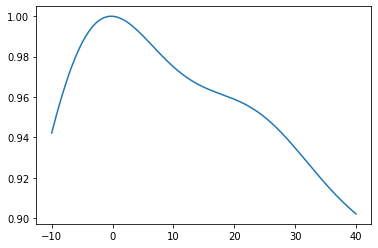

SN2002cr Ia 



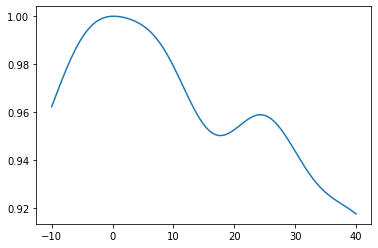

SN2002de Ia 



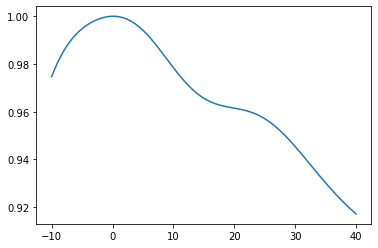

SN2002eb Ia 



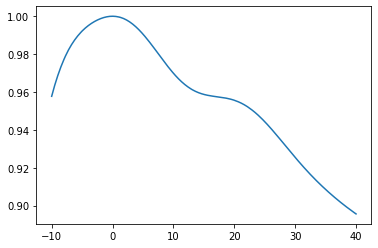

SN2002er Ia 



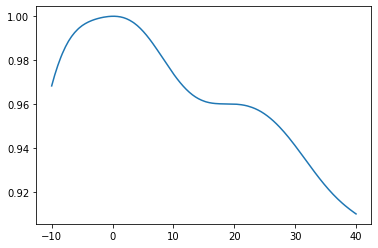

SN2002fk Ia 



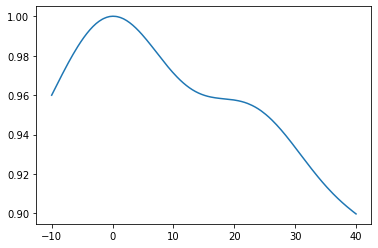

SN2003cg Ia 



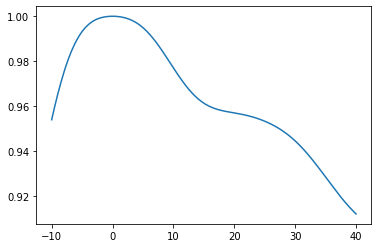

SN2003du Ia 



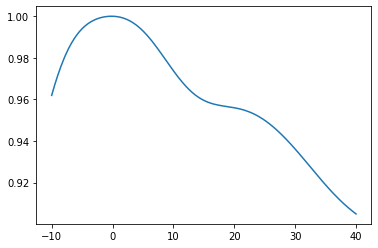

SN2003gt Ia 



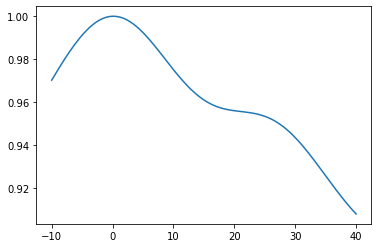

SN2003he Ia 



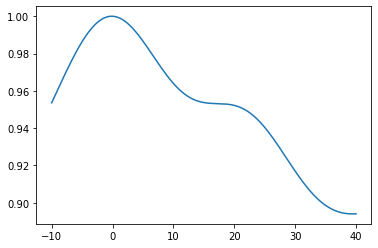

SN2004bw Ia 



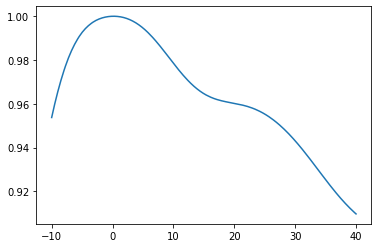

SN2005cf Ia 



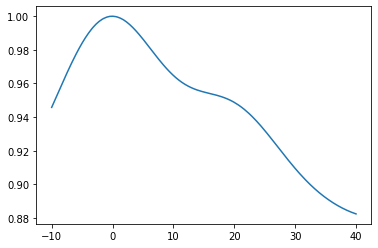

SN2006dm Ia 



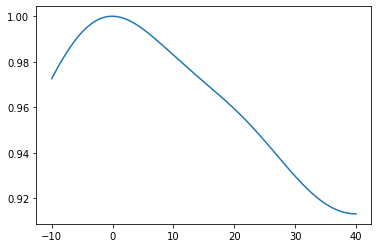

SN2006eu Ia 



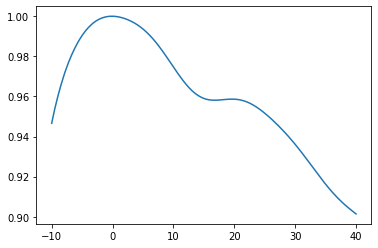

SN2011fe Ia 



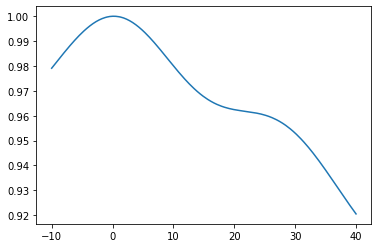

SN2011fs Ia 



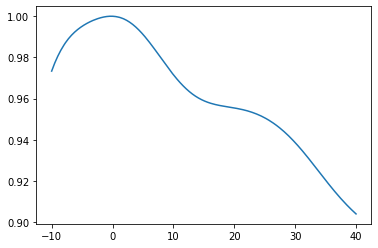

SN2012cg Ia 



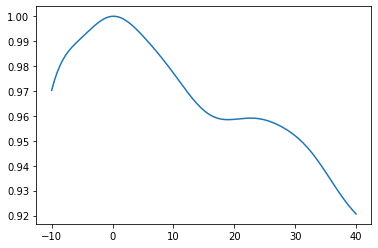

SN2012fr Ia 



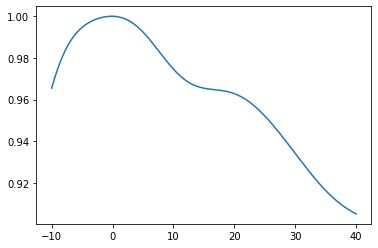

SN2013gy Ia 



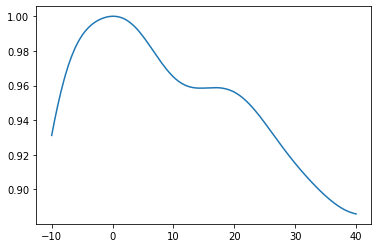

SN2016coj Ia 



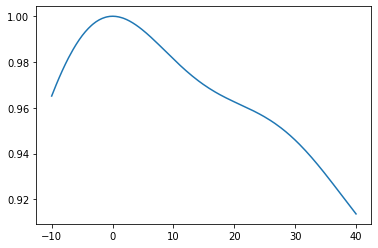

SN2016hvl Ia 



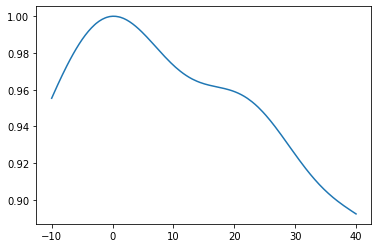

SN2017drh Ia 



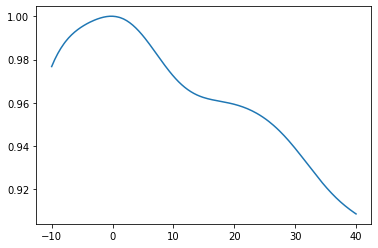

SN2017erp Ia 



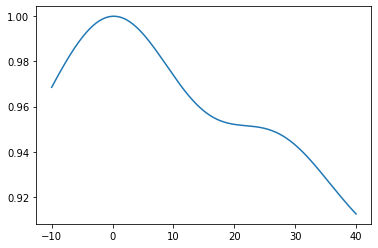

SN2018gv Ia 



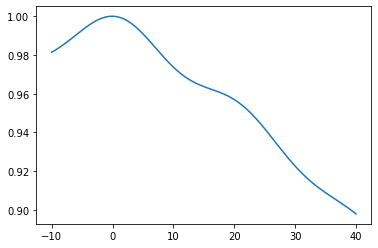

SN2007bc Ia 



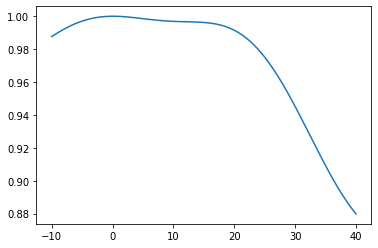

PTF11izt II 



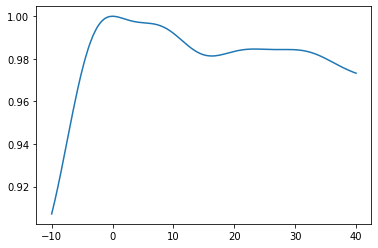

PTF11go II 



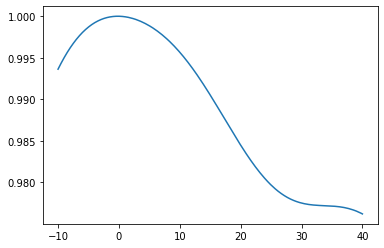

PTF11cwi II 



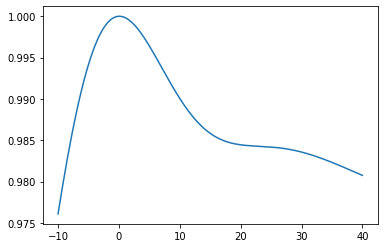

PTF10xtq II 



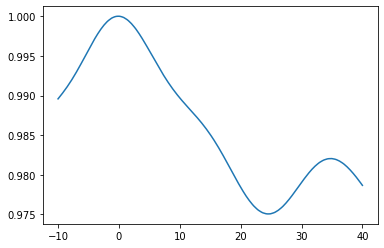

PTF10umz II 



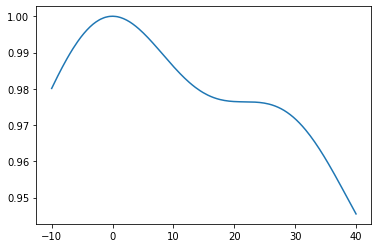

PTF10jwr II 



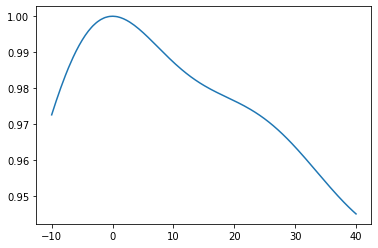

PTF10iam II 



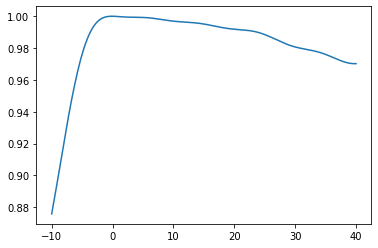

PTF10gva II 



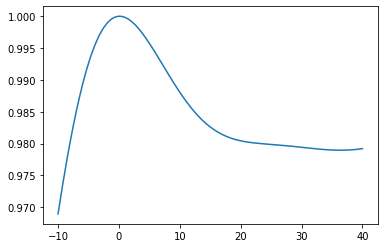

PTF10bgl II 



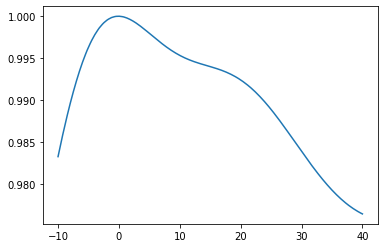

PTF09fma II 



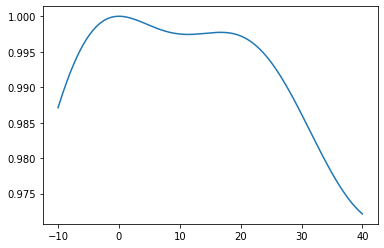

PTF09cjq II 



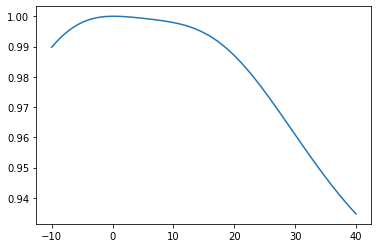

SN2005ci II 



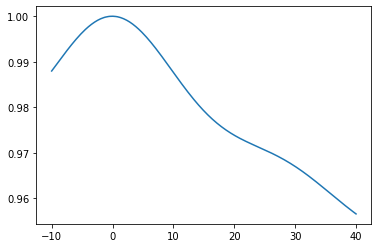

SN2008aw II 



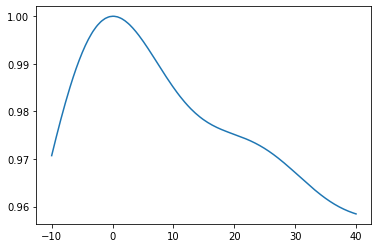

SN2008bx II 



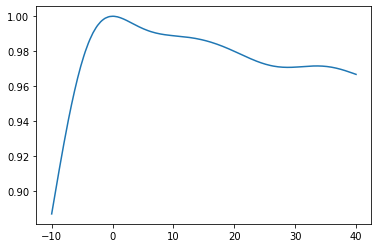

SN2009bw II 



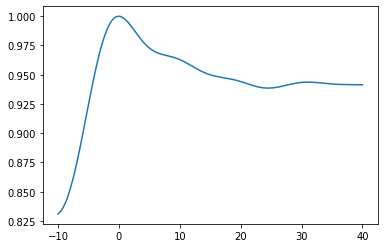

SN2016bkv II 



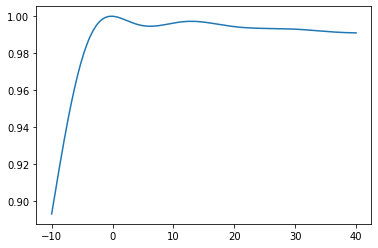

iPTF13dkz II 



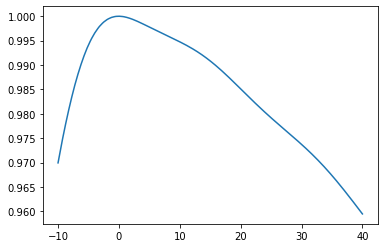

iPTF14adz II 



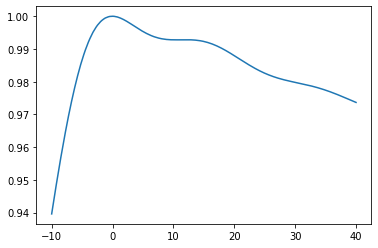

SN2016esw II 



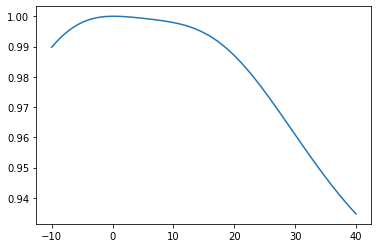

SN2005ci II 



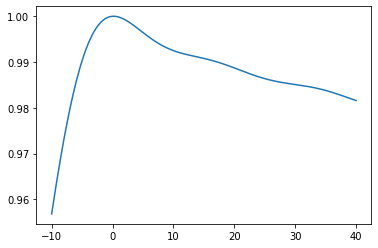

SN2004du II 



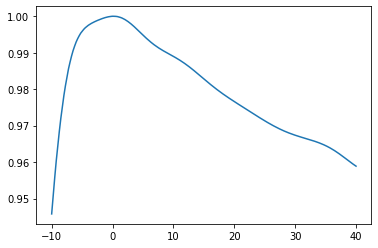

PTF10uls II 



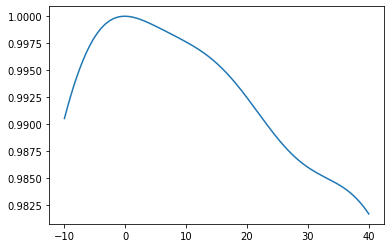

SN2005cl II 



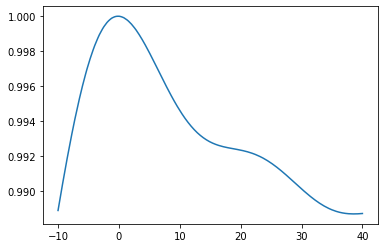

SN2009ib II 



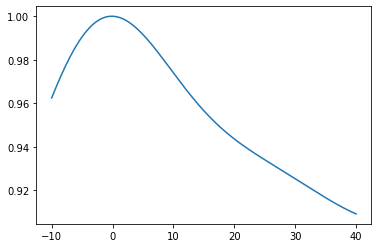

SN2004gq Ib/c 



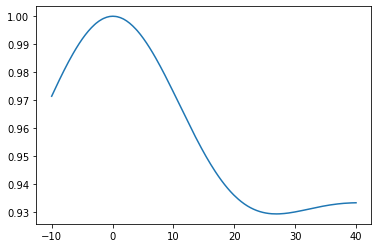

SN2006F Ib/c 



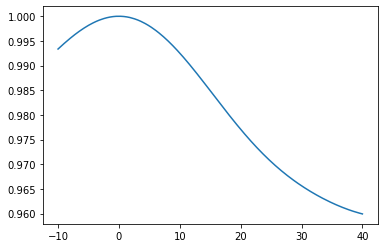

SN2006dn Ib/c 



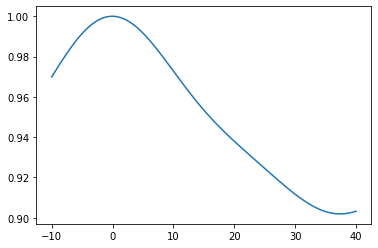

SN2007C Ib/c 



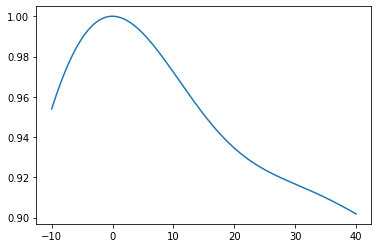

SN2008ax Ib/c 



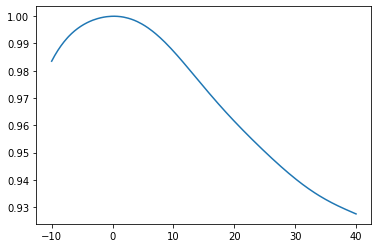

SN2009jf Ib/c 



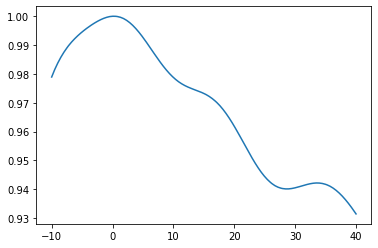

SN2016coi Ib/c 



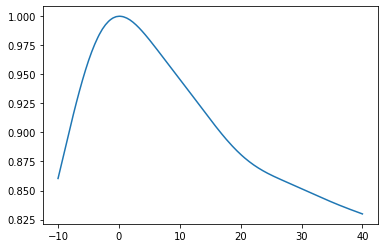

SN1994I Ib/c 



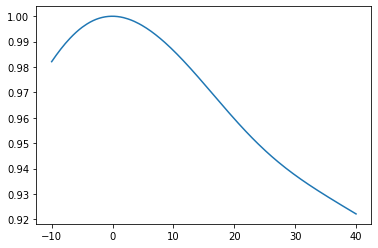

SN2004aw Ib/c 



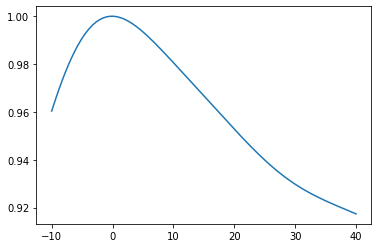

SN2004dn Ib/c 



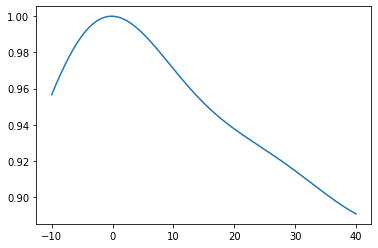

SN2004fe Ib/c 



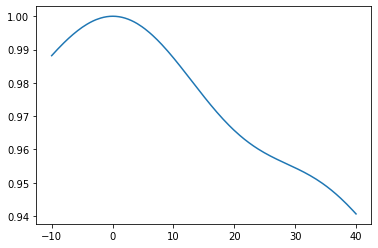

SN2004gt Ib/c 



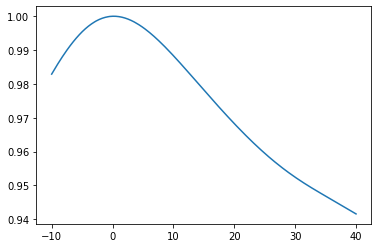

SN2005az Ib/c 



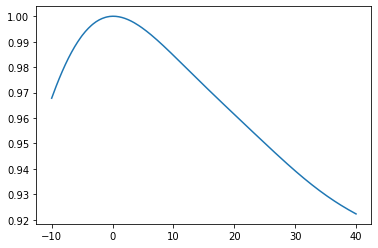

SN2005hg Ib/c 



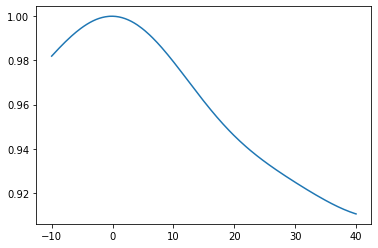

SN2005mf Ib/c 



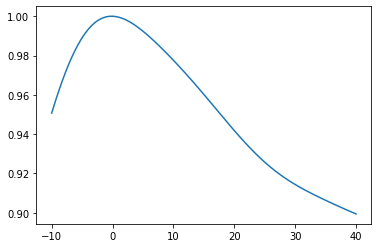

SN2007gr Ib/c 



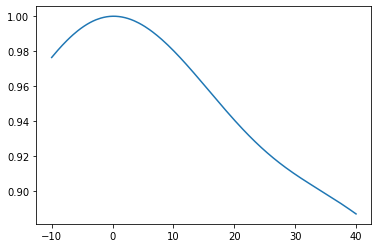

SN2007ru Ib/c 



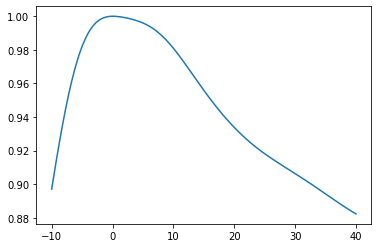

SN2009bb Ib/c 



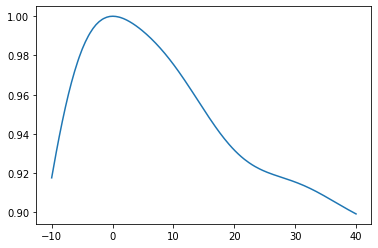

SN2014L Ib/c 



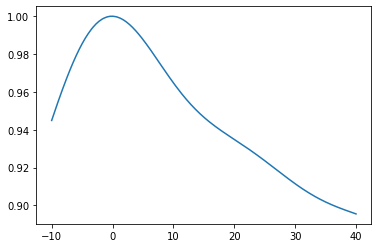

SN2014ad Ib/c 



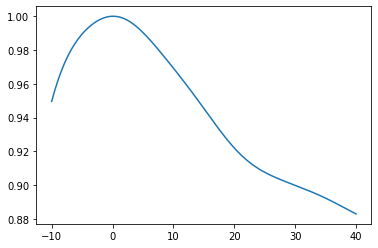

SN2017ein Ib/c 



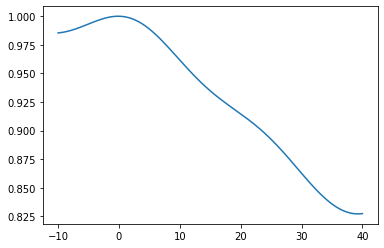

SN2003id Ib/c 



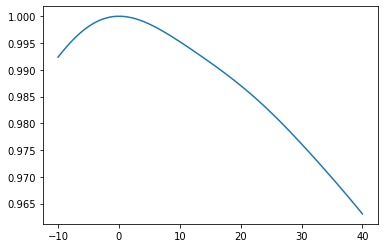

SN2011bm Ib/c 



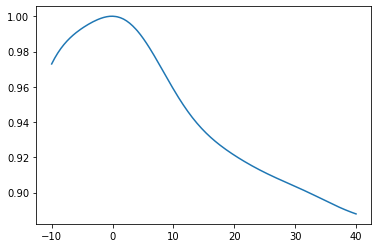

iPTF13bvn Ib/c 



In [8]:
for i, name in enumerate(Ias_names):
    plt.plot(x, Ias_X_norm[i])
    plt.show()
    print(name,Ias_y[i],'\n')
    
for i, name in enumerate(IIs_names):
    plt.plot(x, IIs_X_norm[i])
    plt.show()
    print(name,IIs_y[i],'\n')
    
for i, name in enumerate(Ibcs_names):
    plt.plot(x, Ibcs_X_norm[i])
    plt.show()
    print(name,Ibcs_y[i],'\n')

## Splitting data
The following function, `split_data()`, splits the main sample of SNe into training and testing data. It requires that the LCs are already normalised, and that the data follows the name convention as demonstrated in the [Loading Data](#Loading-Data) section.

This function was defined so that different training-testing sets may be generated when comparing the classifiers.

In [9]:
def split_data(n):
    '''
    Funtion that splits data into training and testing samples for Ia vs. Ib/c vs. II classification.
    
    - Requires normalised light curves to already be defined
    '''
    ints = list(range(len(Ias_X))) # list of numbers 0 - 24
    random.shuffle(ints)           # shuffle these numbers
    for_testing = ints[:n]         # take first n from random sample
    
    # delete the elements corresponding to these indices from main arrays for the training data
    Ias_X_train = np.delete(Ias_X_norm, for_testing, axis=0)
    IIs_X_train = np.delete(IIs_X_norm, for_testing, axis=0)
    Ibcs_X_train = np.delete(Ibcs_X_norm, for_testing, axis=0)

    Ias_y_train = np.delete(Ias_y, for_testing, axis=0)
    IIs_y_train = np.delete(IIs_y, for_testing, axis=0)
    Ibcs_y_train = np.delete(Ibcs_y, for_testing, axis=0)
    
    # take the elements corresponding to these indices from main arrays for the testing data
    Ias_X_test = Ias_X_norm[for_testing]
    IIs_X_test = IIs_X_norm[for_testing]
    Ibcs_X_test = Ibcs_X_norm[for_testing]

    Ias_y_test = Ias_y[for_testing]
    IIs_y_test = IIs_y[for_testing]
    Ibcs_y_test = Ibcs_y[for_testing]
    
    Ias_name_test = Ias_names[for_testing]
    IIs_name_test = IIs_names[for_testing]
    Ibcs_name_test = Ibcs_names[for_testing]
    
    names_test = np.array([Ias_name_test, IIs_name_test, Ibcs_name_test])
    
    # concatenate Ias, IIs, and Ib/cs to make full training and testing sets
    X_train = np.concatenate((Ias_X_train, IIs_X_train, Ibcs_X_train))
    X_test = np.concatenate((Ias_X_test, IIs_X_test, Ibcs_X_test))

    y_train = np.concatenate((Ias_y_train, IIs_y_train, Ibcs_y_train))
    y_test = np.concatenate((Ias_y_test, IIs_y_test, Ibcs_y_test))
    
    return np.array([X_train, y_train, X_test, y_test], dtype=object)

## Import ML algorithms

In [10]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier 
import sklearn.gaussian_process.kernels as skernels
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Compare the classifiers

The following function compares the classifiers. The comparison process is as follows:
1. For each classifier, randomly split the data up into training and testing data.
2. Tune the hyper parameters of the model using this data.
3. Store the average probabilities of classification, the standard deviations of the probabilities, and the mean accuracy of the classifier for the run.
4. Repeat steps 1 – 3 ten times.
5. Average these ten values of mean confidence, standard deviations, and accuracy, and visualise on a bar chart.

In [10]:
def compare_clfs(n=6):
    '''Compare the sklearn clssifiers'''
    # This dictionary has the following format:
    # '(name of classifier)' : [(name of classifier for sklearn), (grid of parameters to perform CV)]
    clf_data = {
        'Support Vector Machine'   : [SVC(probability=True),
                                      {'C': [0.01,0.05,0.1,0.12,0.15,0.2,0.25], 
                                       'gamma': ['scale', 'auto',1,2, 0.1,0.2, 0.01,0.02], 
                                       'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
                                       'tol':[1e-4,1e-3,1e-2],
                                       'degree':[2,3],
                                       'coef0':[0,0.5,1]
                                      }],
        'Random Forest' : [RandomForestClassifier(),
                                      {'n_estimators': [20,30,40],
                                       'criterion': ['gini', 'entropy'], 
                                       'ccp_alpha': [0.0,0.01,0.1,0.001],
                                       'max_features':['auto', 'log2'],
                                       'max_depth': [None,1,2,3,4],
                                       'min_samples_split':[1,2,3],
                                       'min_samples_leaf':[1,2,3]
                                      }],
        'Multi-Layered Perceptron NN' : [MLPClassifier(),
                                         {'hidden_layer_sizes': [(100,), (100,100,), (100,50,)],
                                          'activation':['identity','logistic', 'tanh', 'relu'],
                                          'solver':['lbfgs','sgd','adam'],
                                          'max_iter':[600,800, 1000],
                                          'learning_rate':['constant','invscaling','adaptive']
                                         }],
        'Gaussian Processes' : [GaussianProcessClassifier(),
                                          {'kernel': [skernels.RBF(), skernels.Matern(), skernels.RationalQuadratic()],
                                           'max_iter_predict' : [100,200,300],
                                           'n_restarts_optimizer' : [0,1,2,3,4]
                                           }],
        'Decision Tree' : [DecisionTreeClassifier(),
                                      {'criterion': ['gini','entropy'],
                                       'splitter' : ['best','random'],
                                       'max_depth': [None,1,2,3,4],
                                       'min_samples_split':[1,2,3,4],
                                       'min_samples_leaf':[1,2,3,4]
                                      }],
        'K-Nearest Neighbours' : [KNeighborsClassifier(),
                                 {'n_neighbors': [1,2,3,4,5,6],
                                  'weights': ['uniform', 'distance'], 
                                  'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                                  'leaf_size':[1,2,3,4,6,7,8],
                                  'p': [1,2,3]
                                 }],
        'Adaboost' : [AdaBoostClassifier(),
                     {'n_estimators': [1,2,3,4,5,6,7,8,9,10,50],
                      'learning_rate' : [0.1,0.15,0.175,0.2,0.215,0.25,0.275,0.3,0.35,0.375,0.4,0.45],
                      'algorithm' : ['SAMME', 'SAMME.R']
                     }],
        'Naive Bayes' : [GaussianNB(),
                        {
                         'var_smoothing': [1e-11,1e-12,1e-10,1e-9,1e-8,1e-7,1e-6]
                        }],
        'Linear Discriminant Analysis' : [LinearDiscriminantAnalysis(),
                                         {'solver': ['svd','lsqr','eigen'],
                                         'shrinkage':['auto',0.05,0.1,0.15,1]
                                         }]
    }
    
    Ia_confs_to_plot = [] # where average Ia confidence will be stored
    II_confs_to_plot = [] # where average II confidence will be stored
    Ibc_confs_to_plot = []# where average Ibc confidence will be stored
    
    Ia_stdev_to_plot = [] # where average standard deviation (stdev) of average Ia confidence will be stored
    II_stdev_to_plot = [] # where average stdev of average II confidence will be stored 
    Ibc_stdev_to_plot = []# where average stdev of average Ibc confidence will be stored
    
    clf_scores_to_plot = [] # where average accuracy scores of the classifier will be stored
    clf_std_scores_to_plot = [] # where stdev of average accuracy scores of the classifier will be stored
    
    clf_names = [] # the full names of the classifiers (ie the keys in the dictionary defined above)
    
    for i, (key, value) in enumerate(clf_data.items()):
        Ia_confs = [] # where Ia confidence of each run will be stored
        II_confs = [] # where II confidence of each run will be stored
        Ibc_confs = []# where Ibc confidence of each run will be stored
        
        Ia_stdevs= [] # where stdev of Ia confidence of each run will be stored
        II_stdevs= [] # where stdev of II confidence of each run will be stored
        Ibc_stdevs= []# where stdev of Ibc confidence of each run will be stored
        
        scores = [] # where accuracy of each run will be stored
        
        j=0
        while j < 10:
            X_train, y_train, X_test, y_test = split_data(n=n) # split data
            
            start = time.time()
            
            print('Performing CV on ', key,'. Run number:', j)
            
            optimal_params = GridSearchCV(
                                value[0], 
                                value[1],
                                cv=5,
                                scoring='accuracy', 
                                verbose=0
                            )
            
            optimal_params.fit(X_train, y_train) # perform CV
            
            clf = optimal_params.best_estimator_ # instantiate model
            
            end = time.time()
            
            print('Done in %.2f seconds.' % (end-start))
            
            clf.fit(X_train, y_train) # fit model
            
            clf_score = clf.score(X_test, y_test) # the mean accuracy of the classifier
            clf_probs = clf.predict_proba(X_test) # the predictions for each sample of test set, and their probabilities
            
            scores.append(clf_score)          # record score
            
            Ia_probs = clf_probs[:n]          # probabilities for Ias
            II_probs = clf_probs[n:2*n]       # probabilities for IIs
            Ibc_probs = clf_probs[2*n:]       # probabilities for Ibcs
            
            Ia_conf = Ia_probs[:,1]           # confidence of Ia predictions
            II_conf = II_probs[:,0]           # confidence of II predictions
            Ibc_conf = Ibc_probs[:,2]         # confidence of Ibc predictions

            Ia_mean_conf = np.mean(Ia_conf)   # mean confidence of Ia predictions
            II_mean_conf = np.mean(II_conf)   # mean confidence of II predictions
            Ibc_mean_conf = np.mean(Ibc_conf) # mean confidence of Ibc predictions
            
            Ia_stdev_conf = np.std(Ia_conf)   # standard deviation of Ia predictions
            II_stdev_conf = np.std(II_conf)   # standard deviation of II predictions
            Ibc_stdev_conf = np.std(Ibc_conf) # standard deviation of Ibc predictions
            
            Ia_confs.append(Ia_mean_conf)    # store mean Ia confidence
            II_confs.append(II_mean_conf)    # store mean II confidence
            Ibc_confs.append(Ibc_mean_conf)  # store mean Ibc confidence
            
            Ia_stdevs.append(Ia_stdev_conf)   # store Ia stdev
            II_stdevs.append(II_stdev_conf)   # store II stdev
            Ibc_stdevs.append(Ibc_stdev_conf) # store Ibc stdev
            
            print(Ia_mean_conf, Ia_stdev_conf)
            print(II_mean_conf, II_stdev_conf)
            print(Ibc_mean_conf, Ibc_stdev_conf)
            print(optimal_params.best_estimator_)
            print('\n')
            
            j += 1
        
        # all 10 runs are now finished #
        
        mean_score = np.mean(scores)  # calculate mean accuracy score of all 10 runs
        stdev_scores = np.std(scores) # calculate stdev of accuracy scores of all 10 runs
        
        clf_scores_to_plot.append(mean_score) # store the mean score
        clf_std_scores_to_plot.append(stdev_scores) # store the stdev of the score
        
        Ia_confs_mean = np.mean(Ia_confs) # find the average of the average Ia confidences from each run 
        II_confs_mean = np.mean(II_confs) # find the average of the average II confidences from each run 
        Ibc_confs_mean = np.mean(Ibc_confs) # find the average of the average Ibc confidences from each run 
        
        Ia_stdevs_mean = np.mean(Ia_stdevs) # find the average of the stdevs of Ia confidences from each run 
        II_stdevs_mean = np.mean(II_stdevs) # find the average of the stdevs of II confidences from each run 
        Ibc_stdevs_mean = np.mean(Ibc_stdevs) # find the average of the stdevs of Ibc confidences from each run 
        
        Ia_confs_to_plot.append(Ia_confs_mean) # store the average Ia confidence 
        II_confs_to_plot.append(II_confs_mean) # store the average II confidence 
        Ibc_confs_to_plot.append(Ibc_confs_mean) # store the average Ibc confidence 
        
        Ia_stdev_to_plot.append(Ia_stdevs_mean) # store the average Ia stdev
        II_stdev_to_plot.append(II_stdevs_mean) # store the average II stdev 
        Ibc_stdev_to_plot.append(Ibc_stdevs_mean) # store the average Ibc stdev
        
        clf_names.append(key) # store the name of the classifier
    
    return np.array([np.array(Ia_confs_to_plot), np.array(II_confs_to_plot), np.array(Ibc_confs_to_plot), 
                     np.array(Ia_stdev_to_plot), np.array(II_stdev_to_plot), np.array(Ibc_stdev_to_plot), 
                     np.array(clf_scores_to_plot), np.array(clf_std_scores_to_plot), clf_names], dtype=object)


Note that this next cell took **more than 7 hours to run.**

In [15]:
start = time.time()
Ia_confs_to_plot, II_confs_to_plot, Ibc_confs_to_plot, Ia_stdev_to_plot, II_stdev_to_plot, Ibc_stdev_to_plot,scores, clf_std_scores_to_plot, clf_names = compare_clfs()
end = time.time()
print('compare_clf finished in %.2f seconds' % float(end-start))

Performing CV on  Support Vector Machine . Run number: 0
Done in 74.60 seconds.
0.8383073109131614 0.08280578225224969
0.7520638572922645 0.14259601591977583
0.655361675840115 0.3053032393293921
SVC(C=0.01, coef0=0, degree=2, kernel='poly', probability=True, tol=0.0001)


Performing CV on  Support Vector Machine . Run number: 1
Done in 84.82 seconds.
0.7495139050769989 0.1351268889556475
0.9079299563143531 0.04492703017444414
0.9337209836077291 0.06226541330460239
SVC(C=0.12, coef0=0, degree=2, gamma=2, kernel='poly', probability=True,
    tol=0.0001)


Performing CV on  Support Vector Machine . Run number: 2
Done in 53.81 seconds.
0.677939732483488 0.09787950430483516
0.820112266512691 0.1347093406287988
0.7213380213632163 0.30585325402704794
SVC(C=0.01, coef0=0, degree=2, kernel='poly', probability=True, tol=0.0001)


Performing CV on  Support Vector Machine . Run number: 3
Done in 68.50 seconds.
0.7031954582925154 0.2390067078665157
0.6914253312697661 0.23669678552722007
0.803498245

Done in 2274.53 seconds.
0.9164207135831082 0.08301000755477532
0.9918275226409787 0.012271336125024663
0.9530672068674623 0.05233054529174361
MLPClassifier(learning_rate='invscaling', max_iter=800, solver='lbfgs')


Performing CV on  Gaussian Processes . Run number: 0
Done in 48.07 seconds.
0.6056193494618105 0.08982912499513437
0.5984181680530972 0.09844083484755875
0.4429230672448529 0.09534973932423883
GaussianProcessClassifier(kernel=RBF(length_scale=1))


Performing CV on  Gaussian Processes . Run number: 1
Done in 37.97 seconds.
0.5735398528299612 0.07694771525478239
0.7058181106015285 0.029368888902342155
0.44171138568836726 0.14683506473877103
GaussianProcessClassifier(kernel=Matern(length_scale=1, nu=1.5))


Performing CV on  Gaussian Processes . Run number: 2
Done in 40.25 seconds.
0.5503855067579194 0.0855688085407167
0.6671146073795075 0.08126200183926784
0.4297528518110966 0.16981962762005695
GaussianProcessClassifier(kernel=RBF(length_scale=1))


Performing CV on  Gaussi

Done in 21.72 seconds.
0.717044285102998 0.15511225857687636
0.7394652699785725 0.3535439325603495
0.7526510052383796 0.2661623629481869
AdaBoostClassifier(learning_rate=0.35, n_estimators=6)


Performing CV on  Adaboost . Run number: 3
Done in 21.76 seconds.
0.8264391661063936 0.36166285333056075
0.8310310963791706 0.37164840458358706
0.8180774497617204 0.36495141687607235
AdaBoostClassifier(learning_rate=0.45)


Performing CV on  Adaboost . Run number: 4
Done in 21.72 seconds.
0.3698403341179312 0.0096937944028733
0.373229894496044 0.0419733945270902
0.3674111983884949 0.009702220816250325
AdaBoostClassifier(algorithm='SAMME', learning_rate=0.1)


Performing CV on  Adaboost . Run number: 5
Done in 23.83 seconds.
0.369850917807333 0.0033578089680821473
0.3897877145970465 0.004229180910276881
0.37284798414656883 0.019386825044672384
AdaBoostClassifier(algorithm='SAMME', learning_rate=0.15)


Performing CV on  Adaboost . Run number: 6
Done in 21.59 seconds.
0.6201877183877867 0.27115673

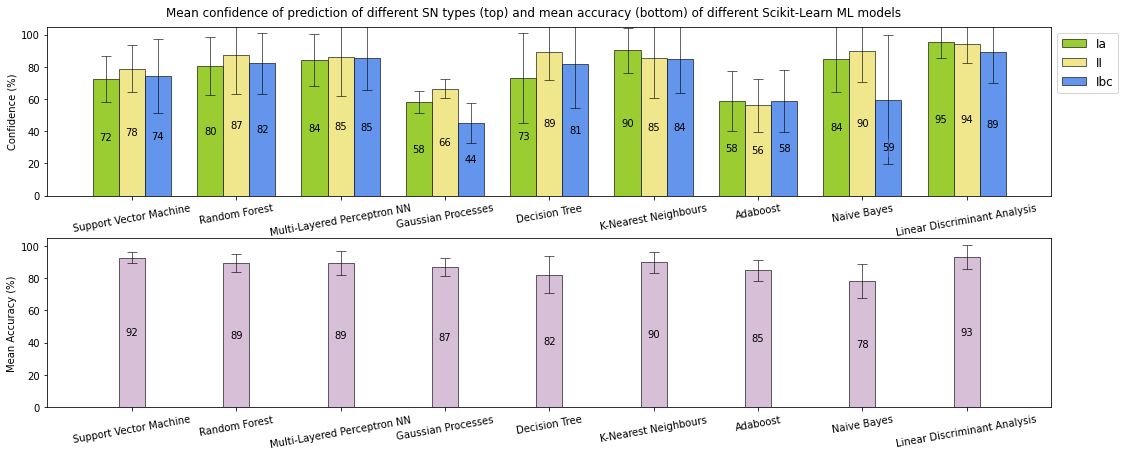

In [20]:
fig = plt.figure(figsize=(18,7))

gs = GridSpec(2,1, fig, hspace=0.25) # create axis grid using gridspec

x = np.arange(len(clf_names))
width = 0.25  # the width of the bars
thickness=0.6 # thickness of error lines

conf_ax = fig.add_subplot(gs[0])

ias = conf_ax.bar(x - width, Ia_confs_to_plot*100, width, 
                  yerr=Ia_stdev_to_plot*100, capsize=5, error_kw={'elinewidth':thickness, 'capthick':thickness},
                  label='Ia', color='yellowgreen', edgecolor = 'k',linewidth=thickness)
iis = conf_ax.bar(x, II_confs_to_plot*100, width,
                  yerr=II_stdev_to_plot*100, capsize=5, error_kw={'elinewidth':thickness,'capthick':thickness},
                  label='II', color='khaki', edgecolor = 'k',linewidth=thickness)
ibcs = conf_ax.bar(x + width, Ibc_confs_to_plot*100, width,
                   yerr=Ibc_stdev_to_plot*100, capsize=5,error_kw={'elinewidth':thickness,'capthick':thickness},
                   label='Ibc', color='cornflowerblue', edgecolor = 'k',linewidth=thickness)

conf_ax.bar_label(ias, label_type='center', fmt = '%i', bbox=dict(facecolor='yellowgreen', edgecolor='none', alpha=0.4))
conf_ax.bar_label(iis, label_type='center', fmt = '%i', bbox=dict(facecolor='khaki', edgecolor='none', alpha=0.4))
conf_ax.bar_label(ibcs, label_type='center', fmt = '%i', bbox=dict(facecolor='cornflowerblue', edgecolor='none', alpha=0.4))

conf_ax.set_xticks(x)
conf_ax.set_xticklabels(clf_names,rotation=10)

conf_ax.set_ylim(0,105)
conf_ax.legend(loc='upper left',bbox_to_anchor=(1, 1), prop={'size': 12})

conf_ax.set_ylabel('Confidence (%)')

score_ax = fig.add_subplot(gs[1], sharex=conf_ax)
score_bars=score_ax.bar(x, scores*100, width,
                       yerr=clf_std_scores_to_plot*100, capsize=5, error_kw={'elinewidth':thickness, 'capthick':thickness},
                       color='thistle', edgecolor = 'k',linewidth=thickness)
score_ax.bar_label(score_bars, label_type='center', fmt = '%i')#, bbox=dict(facecolor='white', edgecolor='none', alpha=thickness))
score_ax.set_xticks(x)
score_ax.set_xticklabels(clf_names,rotation=10)
score_ax.set_ylim(0,105)

score_ax.set_ylabel('Mean Accuracy (%)')
plt.tight_layout()
plt.suptitle('Mean confidence of prediction of different SN types (top) and mean accuracy (bottom) of different Scikit-Learn ML models', y=0.92, size='large')
plt.savefig('conf_score.jpg',dpi=350)
plt.show()